In [1]:
import os
import json
import zarr
import folium
import shutil
import requests
import numpy as np
import pandas as pd
import pyvista as pv
import geopandas as gpd
import matplotlib.pyplot as plt
from time import sleep

In [2]:
# Link the API URL
API_URL = "https://fastfuels.silvx.io"

In [3]:
# Use a demo API key.
# NOTE: Data associated with this key may be deleted at any time.
API_KEY = "sxk-b78b909a-383c-4972-b480-749f9f926a4b"

# Use the key to access the API
HEADERS = {"X-API-KEY": API_KEY}

In [4]:
# Create a request session for interacting with the FastFuels API
session = requests.session()
session.headers.update(HEADERS)

In [5]:
# Reset the user data for new session
resp = session.delete(f"{API_URL}/datasets")

# How to use this notebook

In [6]:
# This notebook uses the Python requests module to communicate with the FastFuels API.
# HTTP methods can be called with session.METHOD(url)
# For example, the following code sends a GET request to https://fastfuels.silvx.io
resp = session.get(API_URL)

In [7]:
# Each API call returns a response object. To view the response data for any cell in the notebook, run the following command:
resp.json()

'Welcome to the FastFuels API'

# Create a spatial data store

In [8]:
# Load a geojson from disk
with open("data/test_geojson.geojson") as f:
    geojson = json.load(f)

In [9]:
# Plot the feature from the GIS API
fmap = folium.Map()
tile = folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='esri').add_to(fmap)
feature_layer = folium.GeoJson(json.dumps(geojson), name='polygon').add_to(fmap)
fmap.fit_bounds(feature_layer.get_bounds())
fmap

# Dataset Endpoints

In [10]:
# Create a FastFuels dataset using an existing feature ID
payload = json.dumps({
        "name": "example_dataset",
        "description": "show an example FastFuels dataset",
        "spatial_data": {"data": geojson},
        "tags": ["example-notebook"]
    })
resp = session.post(f"{API_URL}/datasets", data=payload)
dataset_id = resp.json()["id"]

In [11]:
print(json.dumps(resp.json(), indent=1))

{
 "name": "example_dataset",
 "description": "show an example FastFuels dataset",
 "spatial_data": {
  "bbox": {
   "west": -113.94717919590558,
   "east": -113.94615426856866,
   "north": 46.826770523885266,
   "south": 46.82586367573463
  },
  "epsg": 4326
 },
 "tags": [
  "example-notebook"
 ],
 "created_on": "2023-01-25T00:05:33.494134+00:00",
 "fvs_variant": "IE",
 "id": "4fd7f2baa2a3405d96dd5c9911cf0c57",
 "treelists": [],
 "fuelgrids": [],
 "version": "fastfuels-v0.5.4"
}


In [12]:
# List all FastFuels datasets for a user
resp = session.get(f"{API_URL}/datasets")

In [13]:
# Get a specific FastFuels dataset
resp = session.get(f"{API_URL}/datasets/{dataset_id}")

In [14]:
# Update the name, description, or tag of a dataset
# Note: Any combination of the following payload will update the included fields
payload = json.dumps({
        "name": "updated_dataset_name",
        "description": "update my dataset description",
        "tags": ["updated-tag"]
    })
resp = session.patch(f"{API_URL}/datasets/{dataset_id}", data=payload)

In [15]:
# Delete a specific FastFuels dataset
resp = session.delete(f"{API_URL}/datasets/{dataset_id}")

In [16]:
# Delete ALL FastFuels datasets associated with a user.
# NOTE: This also deletes all tree lists and fuel grids
resp = session.delete(f"{API_URL}/datasets")

In [17]:
# Create a new dataset after deletion
payload = json.dumps({
        "name": "example_dataset",
        "description": "show an example FastFuels dataset",
        "spatial_data": {"data": geojson},
    })
resp = session.post(f"{API_URL}/datasets", data=payload)
dataset_id = resp.json()["id"]

# Treelist Endpoints

In [18]:
# Create a treelist resource from an existing dataset
payload = json.dumps({
    "dataset_id": dataset_id,
    "name": "example-treelist",
    "method": "random"
})
resp = session.post(f"{API_URL}/treelists", data=payload)
treelist_id = resp.json()["id"]

In [19]:
print(json.dumps(resp.json(), indent=1))

{
 "dataset_id": "ff5d08d333124cd7b80f0614514a5515",
 "name": "example-treelist",
 "description": "",
 "method": "random",
 "status": "Queued",
 "created_on": "2023-01-25T00:05:41.962650+00:00",
 "id": "496844f3325b44139543277392753914",
 "summary": {},
 "fuelgrids": [],
 "version": "standgen-v0.3.1"
}


In [20]:
# Get the metadata for a specific treelist
resp = session.get(f"{API_URL}/treelists/{treelist_id}")

In [21]:
# Get all the treelists for a user
resp = session.get(f"{API_URL}/treelists")

In [22]:
# Get only the treelists for a specific dataset
resp = session.get(f"{API_URL}/treelists?dataset_id={dataset_id}")

In [23]:
# Update the name or description of a treelist
payload = json.dumps({
    "name": "new-example-name",
    "description": "my new example description"
})
resp = session.patch(f"{API_URL}/treelists/{treelist_id}", data=payload)

In [24]:
# Wait for the treelist resource to finish processing
resp = session.get(f"{API_URL}/treelists/{treelist_id}")
while resp.json()["status"] != "Finished":
    sleep(2)
    resp = session.get(f"{API_URL}/treelists/{treelist_id}")

# Stream the treelist data as a JSON
resp = session.get(f"{API_URL}/treelists/{treelist_id}/data?fmt=json")

In [25]:
# Read the JSON into a dataframe
json_str = resp.json()
df = pd.read_json(json.dumps(json_str), orient="split")

# Convert the pandas dataframe to geopandas geodataframe
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X_m, df.Y_m), crs="epsg:5070")

# Convert FastFuels CRS EPSG:5070 to EPSG:4326 for plotting on the folium map
gdf = gdf.to_crs(epsg=4326)

# Add trees to the map
gdf.apply(lambda p: folium.CircleMarker(location=(p.geometry.coords[0][1], p.geometry.coords[0][0]), 
                                        radius=2, weight=1).add_to(fmap), axis=1)
fmap

In [26]:
# Delete a treelist and return all remaining treelists
resp = session.delete(f"{API_URL}/treelists/{treelist_id}")

In [27]:
# Delete a treelist and return all remaining treelists in a dataset
# ?dataset_id={dataset_id} specifies which dataset the remaining fuel grids should be queried on
resp = session.delete(f"{API_URL}/treelists/{treelist_id}?dataset_id={dataset_id}")

In [28]:
# Delete ALL treelists a user has created
resp = session.delete(f"{API_URL}/treelists")

In [29]:
# Delete ALL treelists in a dataset
resp = session.delete(f"{API_URL}/treelists?dataset_id={dataset_id}")

In [30]:
# Create a new treelist after deletion and wait for processing to complete
payload = json.dumps({
    "dataset_id": dataset_id,
    "name": "example-treelist",
    "method": "random"
})
resp = session.post(f"{API_URL}/treelists", data=payload)
treelist_id = resp.json()["id"]

while resp.json()["status"] != "Finished":
    sleep(2)
    resp = session.get(f"{API_URL}/treelists/{treelist_id}")

# Fuel Grid Endpoints

In [31]:
# Create a fuel grid resource with a realistic fuel distribution. Can select "homogenous", "random", or "realistic".
payload = json.dumps({
    "dataset_id": dataset_id,
    "treelist_id": treelist_id,
    "name": "test-fuelgrid",
    "description": "test fuelgrid description",
    "distribution_method": "realistic",
    "horizontal_resolution": 1,
    "vertical_Resolution": 1,
    "border_pad": 0
})
resp = session.post(f"{API_URL}/fuelgrids", data=payload)
fuelgrid_id = resp.json()["id"]

In [32]:
print(json.dumps(resp.json(), indent=1))

{
 "dataset_id": "ff5d08d333124cd7b80f0614514a5515",
 "treelist_id": "af9337c9294e4eca9157640491047f1a",
 "name": "test-fuelgrid",
 "description": "test fuelgrid description",
 "surface_fuel_source": "LF_SB40",
 "surface_interpolation_method": "nearest",
 "distribution_method": "realistic",
 "horizontal_resolution": 1.0,
 "vertical_resolution": 1.0,
 "border_pad": 0.0,
 "id": "4b64315adfea4aafa13f47639a724133",
 "status": "Processing",
 "created_on": "2023-01-25T00:05:52.948508+00:00",
 "version": "treevox-v0.5"
}


In [33]:
# Get the metadata for a specific fuel grid
resp = session.get(f"{API_URL}/fuelgrids/{fuelgrid_id}")

In [34]:
# Get all the fuel grid metadata for a user
resp = session.get(f"{API_URL}/fuelgrids")

In [35]:
# Get all the fuel grid metadata associated with a dataset
resp = session.get(f"{API_URL}/fuelgrids?dataset_id={dataset_id}")

In [36]:
# Get all the fuel grid metadata associated with a treelist
resp = session.get(f"{API_URL}/fuelgrids?treelist_id={treelist_id}")

In [37]:
# Update the name or description of a fuel grid
payload = json.dumps({
    "name": "new-example-name",
    "description": "my new example description"
})
resp = session.patch(f"{API_URL}/fuelgrids/{fuelgrid_id}", data=payload)

In [38]:
# Wait for the fuelgrid resource to finish processing
resp = session.get(f"{API_URL}/fuelgrids/{fuelgrid_id}")
while resp.json()["status"] != "Finished":
    sleep(2)
    resp = session.get(f"{API_URL}/fuelgrids/{fuelgrid_id}")

# Stream fuel grid 3D array data to a binary zarr file
resp = session.get(f"{API_URL}/fuelgrids/{fuelgrid_id}/data?fmt=zarr", stream=True)
with open("data/fuel-array.zip", "wb") as out_file:
    shutil.copyfileobj(resp.raw, out_file)

In [39]:
# Open the zarr root and examine the available arrays
zarr_root = zarr.open("data/fuel-array.zip")
print(zarr_root.tree())

/
 ├── canopy
 │   ├── SAV (93, 72, 46) float32
 │   ├── bulk-density (93, 72, 46) float32
 │   └── species-code (93, 72, 46) uint16
 └── surface
     ├── DEM (93, 72) float32
     ├── FMC (93, 72) float32
     ├── SAV (93, 72) float32
     ├── bulk-density (93, 72) float32
     └── fuel-depth (93, 72) float32


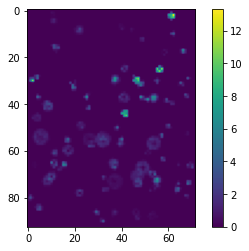

In [40]:
# Plot a 2D sum of the 3D bulk density canopy array
data = zarr_root["canopy"]["bulk-density"][...].sum(axis=2)
plt.imshow(data)
plt.colorbar()
plt.show()

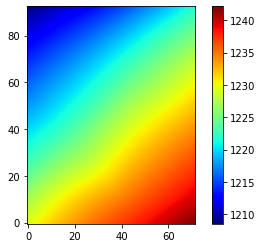

In [41]:
# Plot the DEM. Note: origin="lower" specifies world coordinates with a y-axis oriented top to bottom as North to South.
# By default, Fastfuels data is stored in array coordinates with the y-axis oriented to to bottom as South to North.
data = zarr_root["surface"]["DEM"][...]
plt.imshow(data, cmap="jet", origin="lower")
plt.colorbar()
plt.show()

In [42]:
# Examine a 3D plot of canopy bulk density
data = zarr_root["canopy"]["bulk-density"][...]

# Add surface fuels to the 3D plot
data[..., 0] = zarr_root["surface"]["bulk-density"][...]

# Go from yxz to xyz
data = np.swapaxes(data, 0, 1)

# move zeros to -1 for thresholding
data[data == 0] = -1

# convert the 3D array to a Pyvista UniformGrid
grid = pv.UniformGrid()
grid.dimensions = np.array(data.shape) + 1
grid.spacing = [1, 1, 1]
grid.cell_data['values'] = data.flatten(order='F')
grid = grid.threshold(0)

# Plot the grid
pv.set_plot_theme('document')
grid.plot(cmap='summer')

2023-01-24 17:05:57.421 (  27.903s) [           E6E1E]       vtkThreshold.cxx:84    WARN| vtkThreshold::ThresholdByUpper was deprecated for VTK 9.1 and will be removed in a future version.


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [43]:
# Delete a treelist and return all a user's remaining treelists
resp = session.delete(f"{API_URL}/fuelgrids/{fuelgrid_id}")

In [44]:
# Delete a treelist and return all a user's remaining fuel grids in a dataset
# treelist_id={treelist_id} will return all remaining fuel grids in a treelist
resp = session.delete(f"{API_URL}/fuelgrids/{fuelgrid_id}?dataset_id={dataset_id}")

In [45]:
# Delete all fuel grids a user has created
resp = session.delete(f"{API_URL}/fuelgrids")

In [46]:
# Delete all fuel grids in a dataset
# treelist_id={treelist_id} will delete all fuel grids in a tree list
resp = session.delete(f"{API_URL}/fuelgrids?dataset_id={dataset_id}")

# Treatment Endpoints

In [47]:
# Thin from below to a target diameter of 20.32cm (8 inches)
payload = json.dumps({
    "dataset_id": dataset_id,
    "treelist_id": treelist_id,
    "name": "test-treatment",
    "description": "example treatment",
    "selection_method": "below",
    "selection_metric": "diameter",
    "target_metric": "diameter",
    "target_value": 20.32
})

resp = session.post(f"{API_URL}/treatments", data=payload)
treatment_id = resp.json()["id"]

In [48]:
# Stream treatment data as JSON
resp = session.get(f"{API_URL}/treelists/{treatment_id}/data?fmt=json")

In [49]:
# Read the JSON into a dataframe
json_str = resp.json()
df = pd.read_json(json.dumps(json_str), orient="split")
df

,SPCD,DIA_cm,HT_m,STATUSCD,CBH_m,CROWN_RADIUS_m,X_m,Y_m
0,202,26.924,13.4112,1,6.70560,1.198429,-1.366750e+06,2.777891e+06
1,202,26.924,13.4112,1,6.70560,1.198429,-1.366765e+06,2.777886e+06
2,202,36.068,15.8496,1,7.13232,1.557958,-1.366754e+06,2.777924e+06
3,202,31.242,13.7160,1,9.60120,0.735400,-1.366767e+06,2.777888e+06
4,202,25.400,12.1920,1,7.31520,0.871585,-1.366744e+06,2.777895e+06
...,...,...,...,...,...,...,...,...
90,122,NaN,NaN,2,NaN,NaN,-1.366721e+06,2.777865e+06
91,122,NaN,NaN,3,NaN,NaN,-1.366704e+06,2.777879e+06
92,122,NaN,NaN,3,NaN,NaN,-1.366707e+06,2.777866e+06
93,202,NaN,NaN,3,NaN,NaN,-1.366735e+06,2.777863e+06


In [50]:
# Verify that the prescription was met with the treelist metrics
resp = session.get(f"{API_URL}/treelists/{treatment_id}")
print(json.dumps(resp.json()["summary"], indent=1))

{
 "quadratic_mean_diameter": 36.1886408718792,
 "trees_per_area": 123.44617651888552,
 "area": 0.631854320640438,
 "units": "metric",
 "basal_area_per_area": 12.69732014768429
}


In [51]:
# Convert the pandas dataframe to geopandas geodataframe
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X_m, df.Y_m), crs="epsg:5070")

# Convert FastFuels CRS EPSG:5070 to EPSG:4326 for plotting on the folium map
gdf = gdf.to_crs(epsg=4326)

# Add trees to the map, coloring the treated trees as orange
gdf.apply(lambda p: folium.CircleMarker(location=(p.geometry.coords[0][1], p.geometry.coords[0][0]),
                                        radius=2, weight=1, color="orange").add_to(fmap), axis=1)
fmap